In [1]:
#
# Copyright (c) 2021, NVIDIA CORPORATION. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

### Check the TensorRT version

In [4]:
!python3 -c 'import tensorrt; print("TensorRT version: {}".format(tensorrt.__version__))'
!pwd

TensorRT version: 8.4.1.5
/home/TensorRT/quickstart/SemanticSegmentation


### Import required modules

In [7]:
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
from lib.utils.augmentations import letterbox_for_img
import cv2
import matplotlib.pyplot as plt
from PIL import Image

TRT_LOGGER = trt.Logger()

# Filenames of TensorRT plan file and input/output images.
engine_file = "/home/TensorRT/quickstart/SemanticSegmentation/bb.trt"
input_file  = "/home/TensorRT/quickstart/SemanticSegmentation/8e1c1ab0-a8b92173.jpg"
output_file = "out.jpg"

### Utilities for input / output processing

In [33]:
# For torchvision models, input images are loaded in to a range of [0, 1] and
# normalized using mean = [0.485, 0.456, 0.406] and stddev = [0.229, 0.224, 0.225].
def preprocess(image):
    # Mean normalization
    image, ratio, pad = letterbox_for_img(image.copy(), new_shape=640, auto=True)
    mean = np.array([0.485, 0.456, 0.406]).astype('float32')
    stddev = np.array([0.229, 0.224, 0.225]).astype('float32')
    data = (np.asarray(image).astype('float32') / float(255.0) - mean) / stddev
    # Switch from HWC to to CHW order
    # data = np.ascontiguousarray(data)
    
    return np.moveaxis(data, 2, 0)
    
def postprocess(data):
    num_classes = 21
    # create a color palette, selecting a color for each class
    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([palette*i%255 for i in range(num_classes)]).astype("uint8")
    # plot the segmentation predictions for 21 classes in different colors
    img = Image.fromarray(data.astype('uint8'), mode='P')
    img.putpalette(colors)
    return img


### Load TensorRT engine

Deserialize the TensorRT engine from specified plan file. 

In [20]:
def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

### Inference pipeline

Starting with a deserialized engine, TensorRT inference pipeline consists of the following steps:
- Create an execution context and specify input shape (based on the image dimensions for inference).
- Allocate CUDA device memory for input and output.
- Allocate CUDA page-locked host memory to efficiently copy back the output.
- Transfer the processed image data into input memory using asynchronous host-to-device CUDA copy.
- Kickoff the TensorRT inference pipeline using the asynchronous execute API.
- Transfer the segmentation output back into pagelocked host memory using device-to-host CUDA copy.
- Synchronize the stream used for data transfers and inference execution to ensure all operations are completes.
- Finally, write out the segmentation output to an image file for visualization.

In [36]:
def infer(engine, input_file, output_file):
    print("Reading input image from file {}".format(input_file))
    img = cv2.imread(input_file,cv2.IMREAD_COLOR |cv2.IMREAD_IGNORE_ORIENTATION)
    input_image = preprocess(img)
    image_width, image_height = input_image.shape[1:3]

    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input"), (1, 3, 384, 640))
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            print('size: ',size)
            print('type: ',dtype)
            if engine.binding_is_input(binding):
                input_buffer = np.ascontiguousarray(input_image)
                input_memory = cuda.mem_alloc(input_image.nbytes)
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))

        stream = cuda.Stream()
        # Transfer input data to the GPU.
        cuda.memcpy_htod_async(input_memory, input_buffer, stream)
        # Run inference
        context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
        # Transfer prediction output from the GPU.
        cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
        # Synchronize the stream
        stream.synchronize()
        return output_buffer
    # with postprocess(np.reshape(output_buffer, (image_height, image_width))) as img:
    #     print("Writing output image to file {}".format(output_file))
    #     img.convert('RGB').save(output_file, "PPM")

### Plot input image

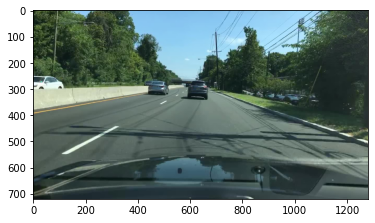

In [5]:
plt.imshow(Image.open(input_file))

### Run inference

In [37]:
print("Running TensorRT inference for FCN-ResNet101")
with load_engine(engine_file) as engine:
    ret = infer(engine, input_file, output_file)
print(ret)

Running TensorRT inference for FCN-ResNet101
Reading engine from file /home/TensorRT/quickstart/SemanticSegmentation/bb.trt
Reading input image from file /home/TensorRT/quickstart/SemanticSegmentation/8e1c1ab0-a8b92173.jpg
size:  737280
type:  <class 'numpy.float16'>
size:  61440
type:  <class 'numpy.float16'>
size:  122880
type:  <class 'numpy.float16'>
size:  983040
type:  <class 'numpy.float16'>
[nan nan nan ... nan nan nan]


### Plot segmentation output

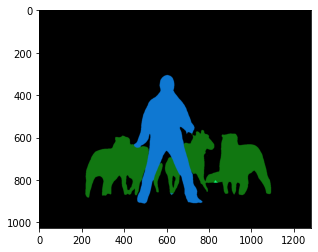

In [ ]:
plt.imshow(Image.open(output_file))